In [11]:
from classifier import TransferLearning
from torchvision import models, transforms
from dataset import ImagesDataset
from torch import optim, nn
import torch
from torchvision.models import resnet50
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models.detection.mask_rcnn import MaskRCNN
from torchvision.models.detection.backbone_utils import LastLevelMaxPool
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork
from torchvision.models import ResNet50_Weights
from torchvision.models import resnet50

In [12]:
model = TransferLearning()
model.eval()

TransferLearning(
  (layers): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
  

In [13]:
from torchvision.models.feature_extraction import get_graph_node_names
from pprint import pprint

train_nodes, eval_nodes = get_graph_node_names(model)

assert([t == e for t, e in zip(train_nodes, eval_nodes)])

pprint(train_nodes)

['x',
 'layers.conv1',
 'layers.bn1',
 'layers.relu',
 'layers.maxpool',
 'layers.layer1.0.conv1',
 'layers.layer1.0.bn1',
 'layers.layer1.0.relu',
 'layers.layer1.0.conv2',
 'layers.layer1.0.bn2',
 'layers.layer1.0.relu_1',
 'layers.layer1.0.conv3',
 'layers.layer1.0.bn3',
 'layers.layer1.0.downsample.0',
 'layers.layer1.0.downsample.1',
 'layers.layer1.0.add',
 'layers.layer1.0.relu_2',
 'layers.layer1.1.conv1',
 'layers.layer1.1.bn1',
 'layers.layer1.1.relu',
 'layers.layer1.1.conv2',
 'layers.layer1.1.bn2',
 'layers.layer1.1.relu_1',
 'layers.layer1.1.conv3',
 'layers.layer1.1.bn3',
 'layers.layer1.1.add',
 'layers.layer1.1.relu_2',
 'layers.layer1.2.conv1',
 'layers.layer1.2.bn1',
 'layers.layer1.2.relu',
 'layers.layer1.2.conv2',
 'layers.layer1.2.bn2',
 'layers.layer1.2.relu_1',
 'layers.layer1.2.conv3',
 'layers.layer1.2.bn3',
 'layers.layer1.2.add',
 'layers.layer1.2.relu_2',
 'layers.layer2.0.conv1',
 'layers.layer2.0.bn1',
 'layers.layer2.0.relu',
 'layers.layer2.0.conv2',
 

In [14]:
from torchvision.models.feature_extraction import create_feature_extractor
import random
import seaborn as sns
import matplotlib.pyplot as plt
from dataset import ImagesDataset
from image_processor import ImageProcessor
from random import randrange

return_nodes = ['layers.layer1', 'layers.layer2', 'layers.layer3', 'layers.layer4']

feat_ext = create_feature_extractor(model, return_nodes=return_nodes)
# print(isinstance(feat_ext, torch.fx.GraphModule))
image_size = 384
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomCrop((image_size), pad_if_needed=True),
    transforms.ToTensor(),
    ]) 
dataset = ImagesDataset(transform=transform)
img, cat_idx = dataset[randrange(7500)]

# print(img)

with torch.no_grad():
    out = feat_ext(img.unsqueeze(0))

# out.keys()
# print(out['layers.layer1'].shape) # reduction = 4 at layer 1, image size reduced by 4
# print(out['layers.layer2'].shape)
# print(out['layers.layer3'].shape)
# print(out['layers.layer4'].shape)

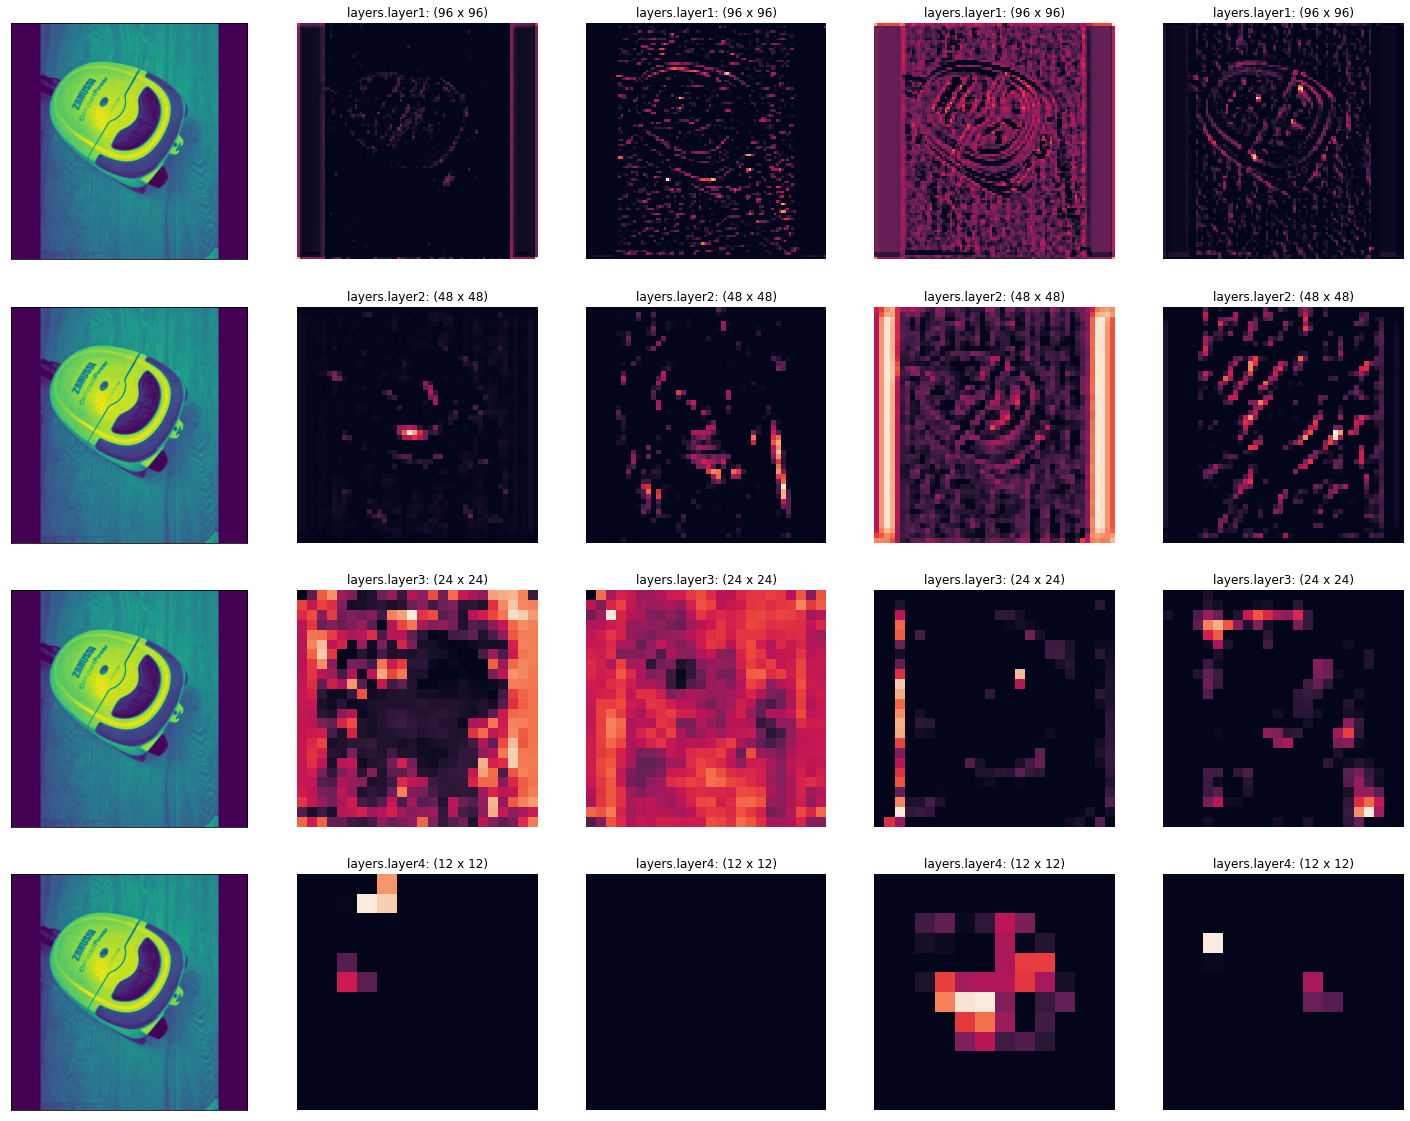

In [15]:
fig, ax = plt.subplots(4, 5, figsize=(25, 20))

# Pick 4 random feature maps from each layer
for i, layer in enumerate(return_nodes):
    feat_maps = out[layer].numpy().squeeze(0)
    feat_maps = random.sample(list(feat_maps), 4)
    ax[i][0].imshow(img[0])
    ax[i][0].set_xticks([])
    ax[i][0].set_yticks([])
    for j, feat_map in enumerate(feat_maps):
        sns.heatmap(feat_map, ax=ax[i][j+1], cbar=False)
        ax[i][j+1].set_xticks([])
        ax[i][j+1].set_yticks([])
        ax[i][j+1].set_title(f'{layer}: ({feat_map.shape[0]} x {feat_map.shape[1]})')

In [16]:
# feat_ext.graph.print_tabular()